<h2>Libraries</h2>

In [2]:
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import skimage.measure   
import tensorflow as tf
from skimage import data
import scipy.ndimage as ndi
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from tensorflow.keras import regularizers
from skimage.measure.entropy import shannon_entropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam , Adamax
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix , classification_report
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense,BatchNormalization
from tensorflow.keras.models import load_model
import torch



<h2>Loading the dataset</h2>

In [3]:
#Train
train_glioma = glob.glob('./dataset/Training/glioma_tumor/*.jpg')
train_menignioma = glob.glob('./dataset/Training/meningioma_tumor/*.jpg')
train_pituitary = glob.glob('./dataset/Training/pituitary_tumor/*.jpg')
train_no = glob.glob('./dataset/Training/no_tumor/*.jpg')

#Test
test_glioma = glob.glob('./dataset/Testing/glioma_tumor/*.jpg')
test_menignioma = glob.glob('./dataset/Testing/meningioma_tumor/*.jpg')
test_pituitary = glob.glob('./dataset/Testing/pituitary_tumor/*.jpg')
test_no = glob.glob('./dataset/Testing/no_tumor/*.jpg')

<h2>Data analysis</h2>

In [4]:
train_glioma_number = len(train_glioma)
train_menignioma_number = len(train_menignioma)
train_pituitary_number = len(train_pituitary)
train_no_number = len(train_no)

test_glioma_number = len(test_glioma)
test_menignioma_number = len(test_menignioma)
test_pituitary_number = len(test_pituitary)
test_no_number = len(test_no)

print("Number of train_glioma: ",train_glioma_number)
print("Number of train_menignioma: ",train_menignioma_number)
print("Number of train_pituitary: ",train_pituitary_number)
print("Number of train_no: ",train_no_number)
print("Number of test_glioma: ",test_glioma_number)
print("Number of test_menignioma: ",train_menignioma_number)
print("Number of test_pituitary: ",train_pituitary_number)
print("Number of test_no: ",train_no_number)

Number of train_glioma:  826
Number of train_menignioma:  822
Number of train_pituitary:  827
Number of train_no:  395
Number of test_glioma:  100
Number of test_menignioma:  822
Number of test_pituitary:  827
Number of test_no:  395


<h3>Pie-chart of the Train image</h3>


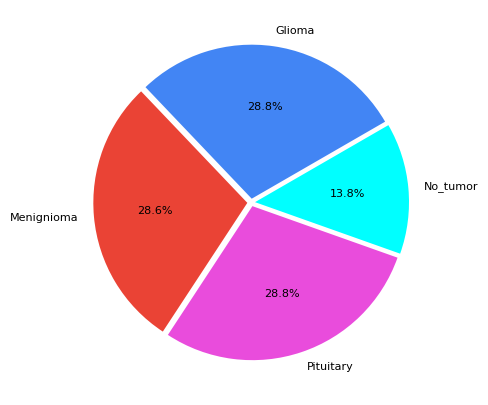

In [5]:
plt.figure(figsize=(5,5))
colors = ['#4285f4','#ea4335',"#e94cdc","#00FFFF"]
plt.rcParams.update({'font.size': 8})
plt.pie([train_glioma_number,
         train_menignioma_number,train_pituitary_number,train_no_number],
        labels=['Glioma', 'Menignioma','Pituitary','No_tumor'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

<h3>Pie-chart of the Test image</h3>

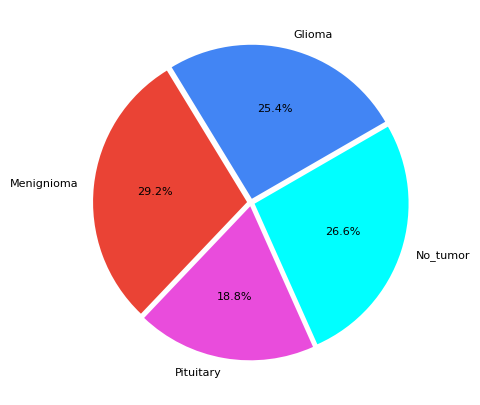

In [6]:
plt.figure(figsize=(5,5))
colors = ['#4285f4','#ea4335',"#e94cdc","#00FFFF"]
plt.rcParams.update({'font.size': 8})
plt.pie([test_glioma_number,
         test_menignioma_number,test_pituitary_number,test_no_number],
        labels=['Glioma', 'Menignioma','Pituitary','No_tumor'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

<h3>Pie-chart of the Test and Train image</h3>

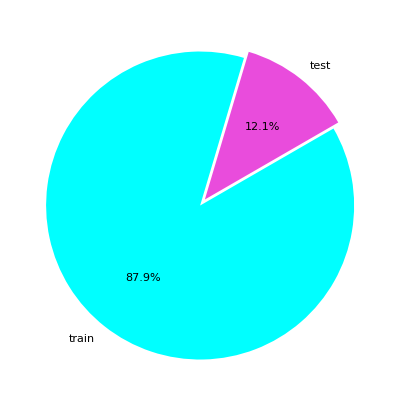

In [7]:
plt.figure(figsize=(5,5))
colors = ["#e94cdc","#00FFFF"]
plt.rcParams.update({'font.size': 8})
plt.pie([test_glioma_number+
         test_menignioma_number+test_pituitary_number+test_no_number,train_glioma_number+
         train_menignioma_number+train_pituitary_number+train_no_number],
        labels=['test', 'train'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025),
        startangle=30);

In [8]:
print('total train data:',(train_glioma_number+
         train_menignioma_number+train_pituitary_number+train_no_number))
print('total test data:',(test_glioma_number+test_menignioma_number+test_pituitary_number+test_no_number))

total train data: 2870
total test data: 394


<h3>Image Visualization</h3>

In [9]:
def images_visualization(image, title,a):#a=number of images
    plt.figure(figsize=(8,8))#image size
    for i in range(a):#number of image
        random_image_path = random.choice(image)#random selection
        img = mpimg.imread(random_image_path)
        plt.subplot(1, a, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(title)
    plt.show()

Train image visualisation



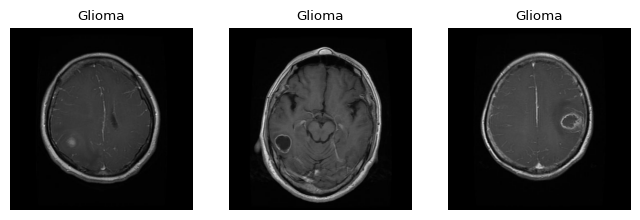

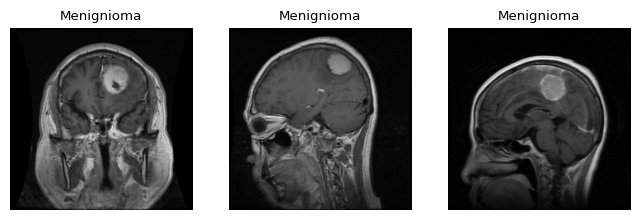

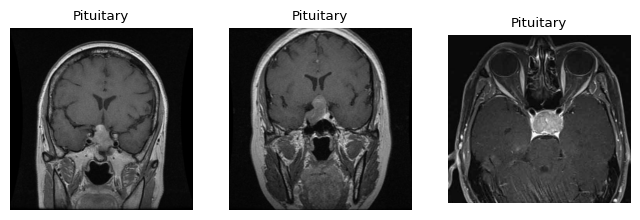

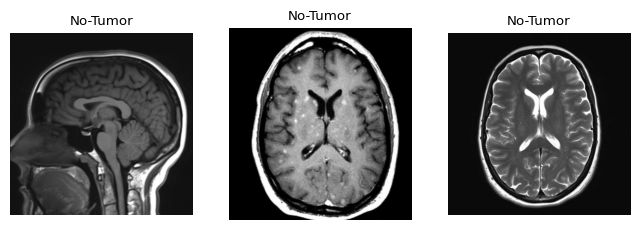

In [10]:
print("Train image visualisation\n")
images_visualization(train_glioma, 'Glioma',3)
images_visualization(train_menignioma, 'Menignioma',3)
images_visualization(train_pituitary, 'Pituitary',3)
images_visualization(train_no, 'No-Tumor',3)

<h2>Image Visualization</h2>


<h3>Convolutoin Filter definition</h3>

In [11]:
def fiter(image, title,a,m):#a=number of images, m = filter matrix
    plt.figure(figsize=(8,8))#image size
    for i in range(a):#number of image
        random_image_path = random.choice(image)#random selection
        img = cv2.imread(random_image_path) # read the image using cv2
        laplacian_kernel = np.array(m) # define the Laplacian kernel
        laplacian_img = cv2.filter2D(img, -1, laplacian_kernel) # apply the Laplacian filter using cv2.filter2D
        plt.subplot(1, a, i+1)
        plt.imshow(laplacian_img, cmap='jet') # display the filtered image using plt.imshow and cmap='jet'
        plt.axis('off')
        plt.title(title)
    plt.show()

<h4>Convolution Gaussian filter</h4>

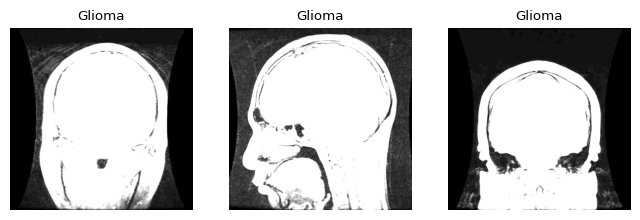

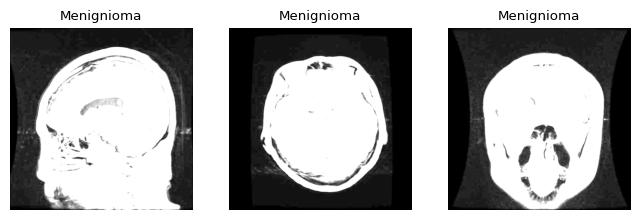

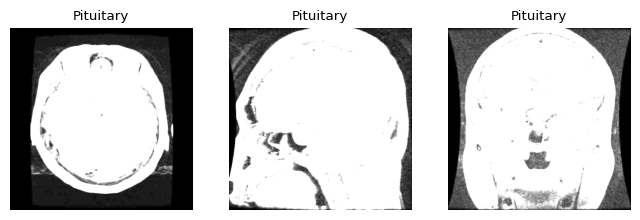

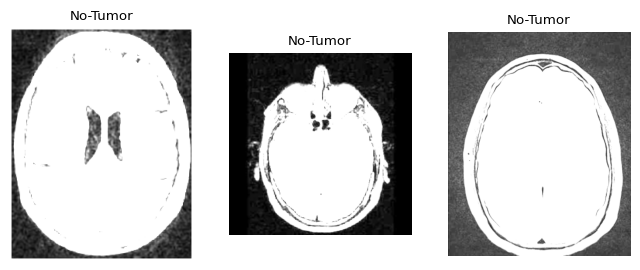

In [12]:
m = [[1, 1, 1], [1, 1, 1], [1, 1, 1]]# Gaussian filter 

fiter(train_glioma, 'Glioma',3,m)
fiter(train_menignioma, 'Menignioma',3,m)
fiter(train_pituitary, 'Pituitary',3,m)
fiter(train_no, 'No-Tumor',3,m)

<h4>Laplacian of Gaussian</h4>

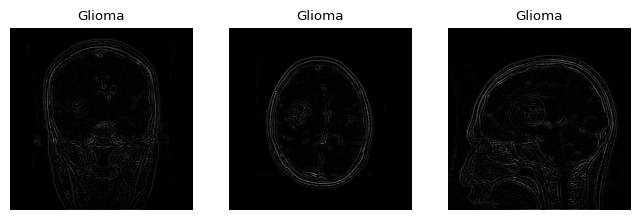

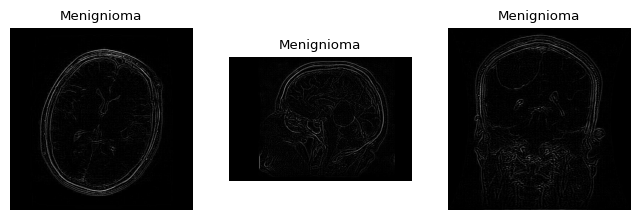

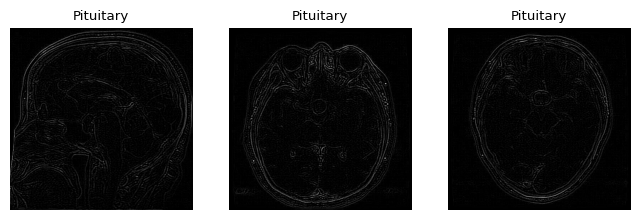

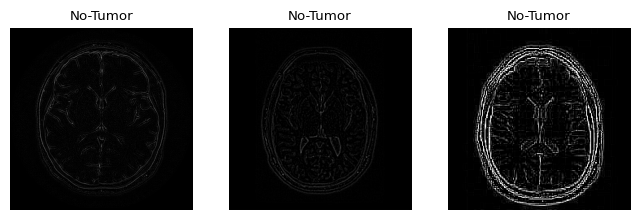

In [13]:
m =  [[1, 1, 1], [1, -8, 1], [1, 1, 1]]#laplacian of Gaussian filter 

fiter(train_glioma, 'Glioma',3,m)
fiter(train_menignioma, 'Menignioma',3,m)
fiter(train_pituitary, 'Pituitary',3,m)
fiter(train_no, 'No-Tumor',3,m)

<h4>Laplacian of Gaussian 2</h4>

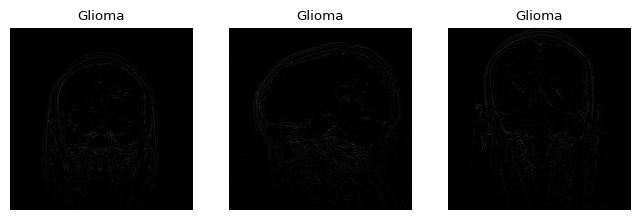

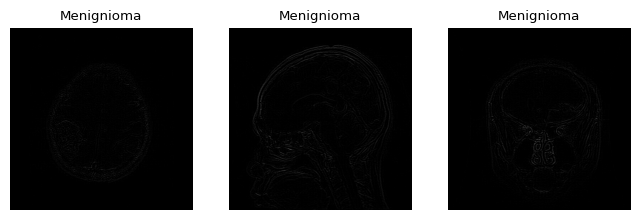

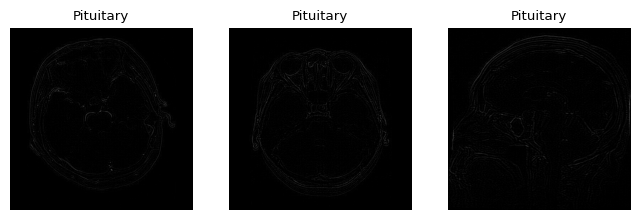

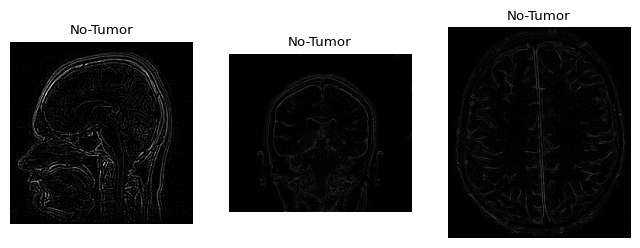

In [14]:
m =  [[0, -1, 0], [-1, 4, -1], [0, -1, 0]]#laplacian of Gaussian filter 

fiter(train_glioma, 'Glioma',3,m)
fiter(train_menignioma, 'Menignioma',3,m)
fiter(train_pituitary, 'Pituitary',3,m)
fiter(train_no, 'No-Tumor',3,m)

<h3>clahe Filter function definition</h3>

In [15]:
def clahe(image, title,a):#a=number of images
    plt.figure(figsize=(8,8))#image size
    for i in range(a):#number of image
        random_image_path = random.choice(image)#random selection
        img = cv2.imread(random_image_path) # read the image using cv2
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert the image to grayscale
        clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(8,8)) # create a CLAHE object with clip limit and tile grid size
        clahe_img = clahe.apply(img_gray) # apply CLAHE to the grayscale image
        plt.subplot(1, a, i+1)
        plt.imshow(clahe_img, cmap='jet') # display the filtered image using plt.imshow and cmap='jet'
        plt.axis('off')
        plt.title(title)
    plt.show()

<h4>Clahe Filter</h4>

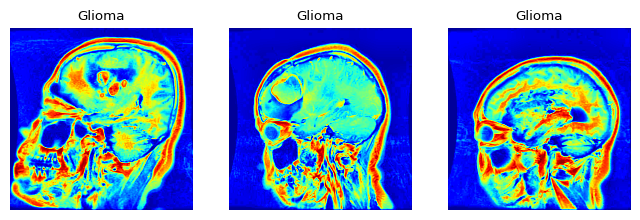

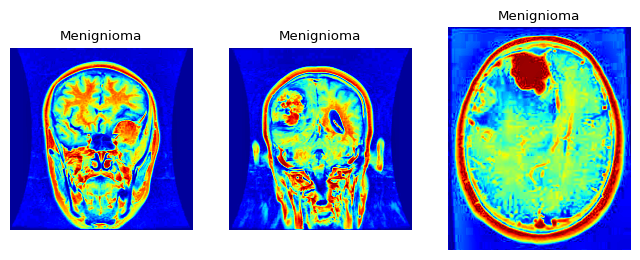

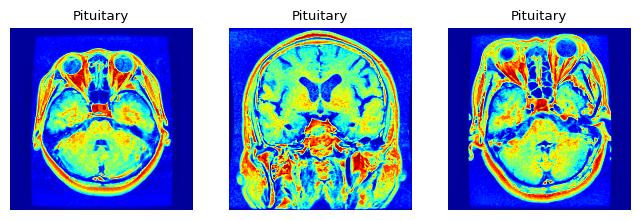

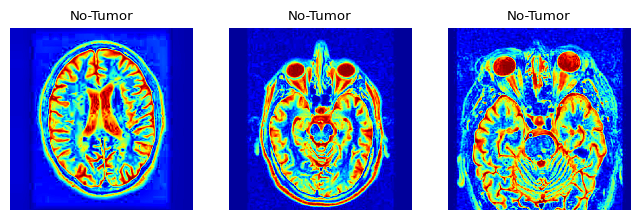

In [16]:
clahe(train_glioma, 'Glioma',3)
clahe(train_menignioma, 'Menignioma',3)
clahe(train_pituitary, 'Pituitary',3)
clahe(train_no,'No-Tumor',3)

<h3>Entropy Shanon filter function definition</h3>

In [17]:
def entr(image, title,a):#a=number of images
    plt.figure(figsize=(8,8))#image size
    for i in range(a):#number of image
        random_image_path = random.choice(image)#random selection
        img = cv2.imread(random_image_path) # read the image using cv2
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert the image to grayscale
        # create a CLAHE object with clip limit and tile grid size
        entr_img = entropy(img_gray, disk(2)) 
        plt.subplot(1, a, i+1)
        plt.imshow(entr_img, cmap='viridis')# display the filtered image using plt.imshow and cmap='jet'
        plt.axis('off')
        plt.title(title)
    plt.show()

<h4>Entropy shanon Filter</h4>

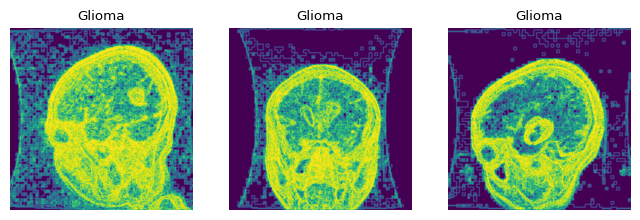

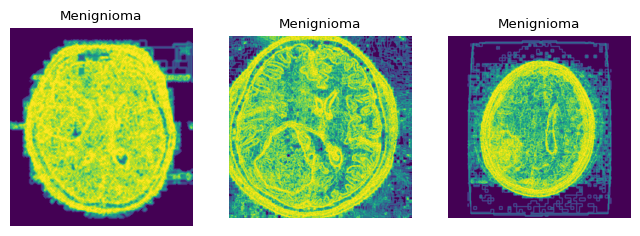

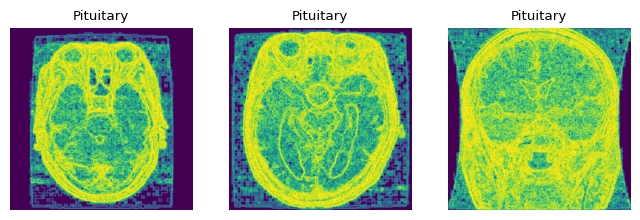

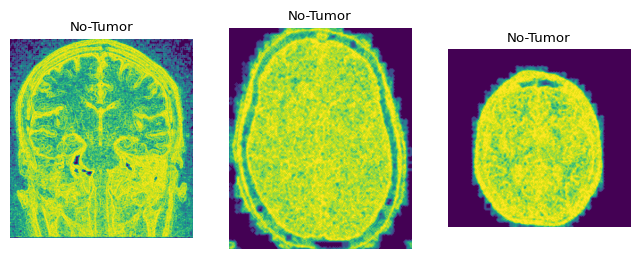

In [18]:
entr(train_glioma, 'Glioma',3)
entr(train_menignioma, 'Menignioma',3)
entr(train_pituitary, 'Pituitary',3)
entr(train_no,'No-Tumor',3)

<h2>Image preprocessing</h2>

<h3>Image dataset creation</h3>

In [19]:
train_data_path = './dataset/Training/'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [20]:
train_df

,filepaths,label
0,./dataset/Training/glioma_tumor\gg (1).jpg,glioma_tumor
1,./dataset/Training/glioma_tumor\gg (10).jpg,glioma_tumor
2,./dataset/Training/glioma_tumor\gg (100).jpg,glioma_tumor
3,./dataset/Training/glioma_tumor\gg (101).jpg,glioma_tumor
4,./dataset/Training/glioma_tumor\gg (102).jpg,glioma_tumor
...,...,...
2865,./dataset/Training/pituitary_tumor\p (95).jpg,pituitary_tumor
2866,./dataset/Training/pituitary_tumor\p (96).jpg,pituitary_tumor
2867,./dataset/Training/pituitary_tumor\p (97).jpg,pituitary_tumor
2868,./dataset/Training/pituitary_tumor\p (98).jpg,pituitary_tumor


In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2870 entries, 0 to 2869
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  2870 non-null   object
 1   label      2870 non-null   object
dtypes: object(2)
memory usage: 45.0+ KB


In [22]:
test_data_path = './dataset/Testing/'

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [23]:
test_df

,filepaths,label
0,./dataset/Testing/glioma_tumor\image(1).jpg,glioma_tumor
1,./dataset/Testing/glioma_tumor\image(10).jpg,glioma_tumor
2,./dataset/Testing/glioma_tumor\image(100).jpg,glioma_tumor
3,./dataset/Testing/glioma_tumor\image(11).jpg,glioma_tumor
4,./dataset/Testing/glioma_tumor\image(12).jpg,glioma_tumor
...,...,...
389,./dataset/Testing/pituitary_tumor\image(95).jpg,pituitary_tumor
390,./dataset/Testing/pituitary_tumor\image(96).jpg,pituitary_tumor
391,./dataset/Testing/pituitary_tumor\image(97).jpg,pituitary_tumor
392,./dataset/Testing/pituitary_tumor\image(98).jpg,pituitary_tumor


In [24]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  394 non-null    object
 1   label      394 non-null    object
dtypes: object(2)
memory usage: 6.3+ KB


<h3>Split dataset</h3>

In [25]:
valid , test = train_test_split(test_df , train_size = 0.5 , shuffle = True , random_state= 42)

<h3>Image resize and generation</h3>

In [26]:
img_size = (220 ,220)#This defines a variable called img_size that stores a tuple of two integers, 220 and 220. This will be used as the target size for resizing the images.
batch_size = 15 # This defines a variable called batch_size that stores an integer, 16. This will be used as the number of images per batch.

tr_gen = ImageDataGenerator()#This creates an instance of the ImageDataGenerator class and assigns it to a variable called tr_gen. This will be used to create the train_gen object later. By default, this does not apply any preprocessing or augmentation to the images, but you can pass some arguments to the constructor to customize it.
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 2870 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.


<h2>Modelling</h2>

<h3>Model architecture</h3>

In [27]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' ,

                                                               input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

#optimizer
model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non-trainable params: 90,375
_______________________________________

<h3>Model training</h3>

In [28]:
Epochs = 1

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

192/192 [==============================] - 387s 2s/step - loss: 7.0151 - accuracy: 0.7976 - val_loss: 6.7991 - val_accuracy: 0.6244
